# Przetwarzanie sygnałów i obrazów: Sprawozdanie 006

### Temat: Filtry cyfrowe
### Imię i nazwisko studenta: Paweł Niewiarowski, Szymon Łupiński
### Data realizacji ćwiczenia: 30.11.2022

In [1]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

# Zadanie 6.1
Napisać funckję realizującą filtr cyfrowy opisany następującym równaniem różnicowym: `y[n] = b0x[n] + b1x[n - 1] + b2[x - 2] a1y[n - 2] - a1y[n - 1] - a2y[n - 2]`, dla parametrów ai, bi podanych przez prowadzącego. Następnie:
    - a) Wygenerować odpowiedź impulsową filtru
    - b) Zweryfikować poprawność implementacji porównując odpowiedź z podpunktu a) z odpowiedzią policzoną przy użyciu funkcji scipy.signal.lfilter
    - c) Wykorzystując funkcję scipy.signal.freqz obliczyć i wykreślić charakterystykę częstotliwościową (amplitudową oraz fazową) badanego filtru,
    - d) Wykorzystując funkcję scipy.signal.tf2zpk wyznaczyć położenie zer i biegunów filtru (przedstawić je na wykresie, na okręgu jednostkowym). Co można powiedzieć o stabilności filtru?
    - e) zakładając, że sygnałem wejściowym x[n] jest szum gaussowski z parametrami μ = 0, σ 2 = 1 (przynajmniej 64 próbki) wygenerować sygnał wyjściowy y[n], a następnie obliczyć i wykreślić widma amplitudowe sygnałów x[n] oraz y[n]. Porównać widmo sygnału przefiltrowanego y[n] z charakterystyką amplitudową filtra z podpunktu c).

### Filtr

In [2]:
A = [1, 0.9, 0.1]
B = [0.1, 0.2, 0.3]


def filtr(x, a=None, b=None):
    if a is None:
        a = A

    if b is None:
        b = B

    y = np.empty(len(x))

    y[0] = b[0] * x[0]
    y[1] = b[0] * x[1] + b[1] * x[0] - a[1] * y[0]  #

    n = 2

    while n < len(x):
        y[n] = b[0] * x[n] + b[1] * x[n - 1] + b[2] * x[n - 2] - a[1] * y[n - 1] - a[2] * y[n - 2]
        n += 1

    return y

### Impuls oraz odpowiedź impulsowa

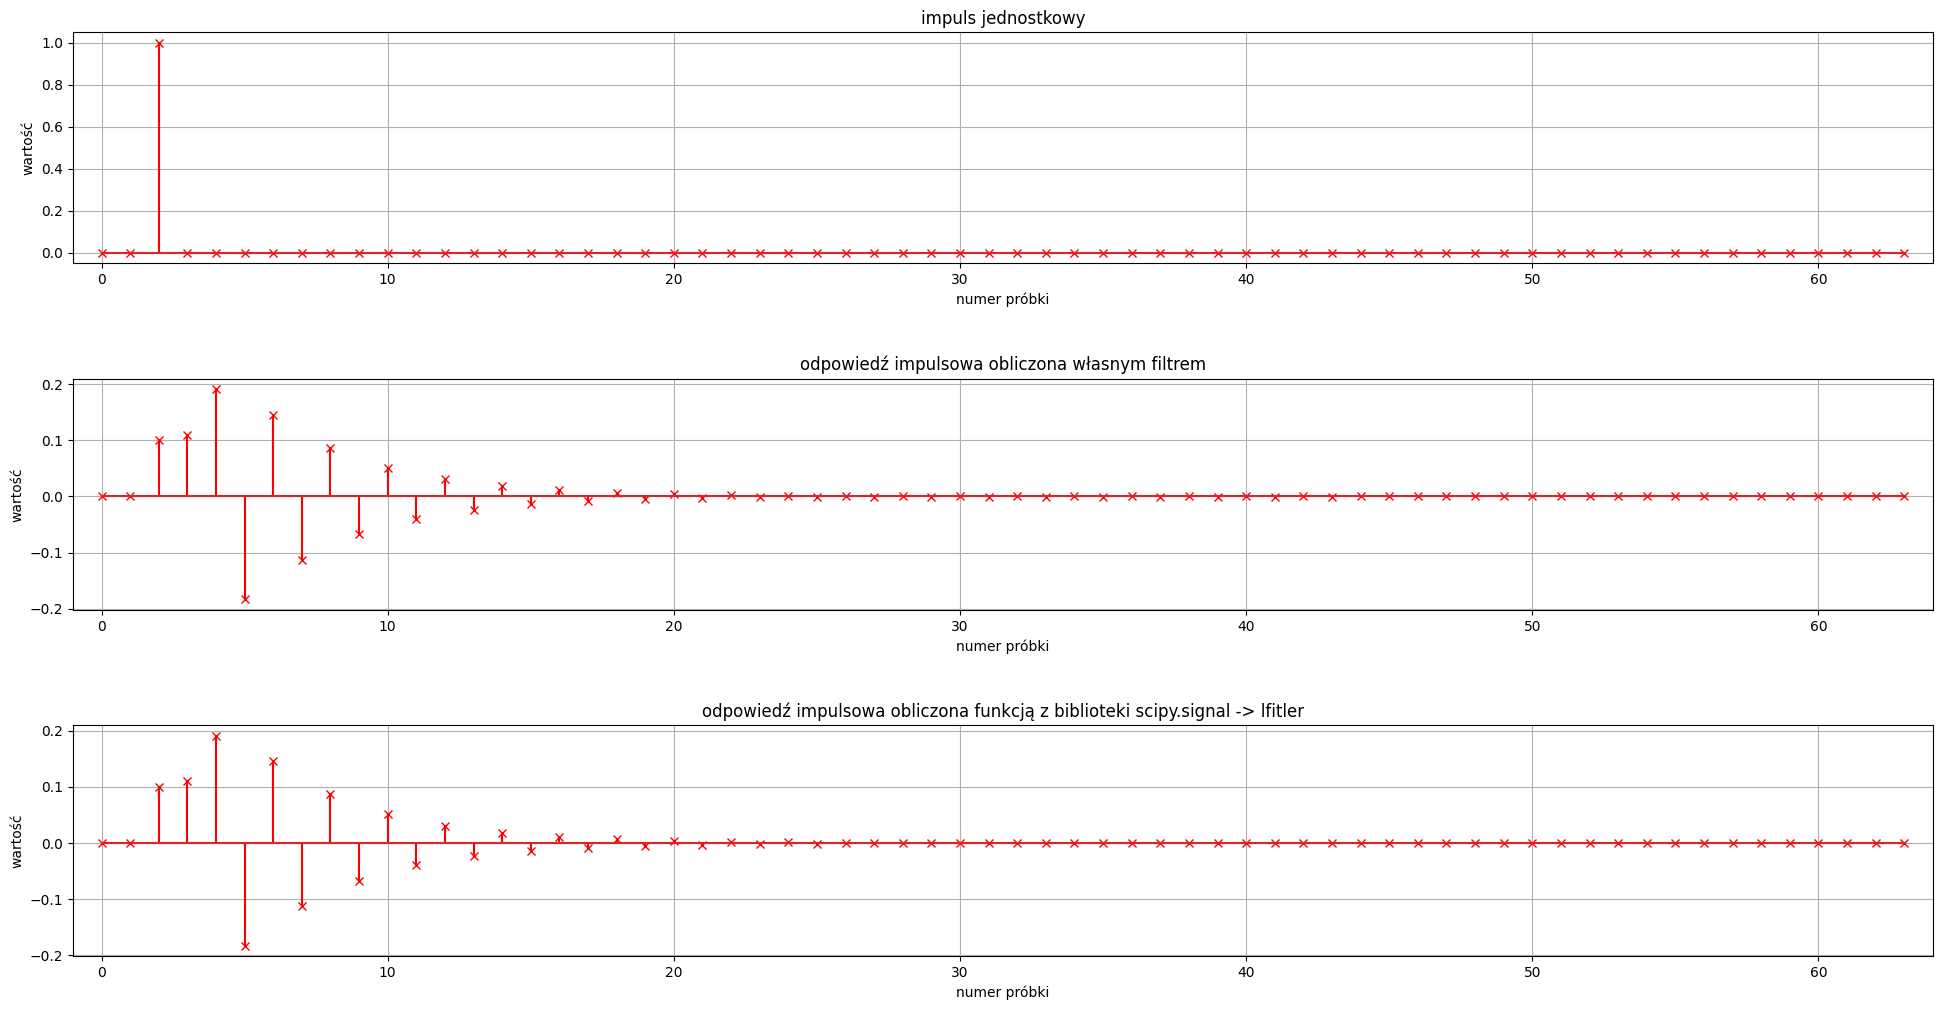

In [3]:
N = 64
DPI = 100

impulse: np.ndarray = np.zeros(N)
impulse[2] = 1

fig, axs = plt.subplots(3)
fig.set_size_inches(24, 12)
fig.set_dpi(DPI)
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for ax in axs:
    ax.set_xlabel('numer próbki')
    ax.set_ylabel('wartość')
    ax.set_xlim(-1, N)
    ax.grid()

axs[0].set_title('impuls jednostkowy')
axs[0].stem(impulse, linefmt='red', markerfmt='x')

axs[1].set_title('odpowiedź impulsowa obliczona własnym filtrem')
axs[1].stem(filtr(impulse), linefmt='red', markerfmt='x')

axs[2].set_title('odpowiedź impulsowa obliczona funkcją z biblioteki scipy.signal -> lfitler')
axs[2].stem(scipy.signal.lfilter(B, A, impulse), linefmt='red', markerfmt='x')

plt.show()

### Charakterystyka

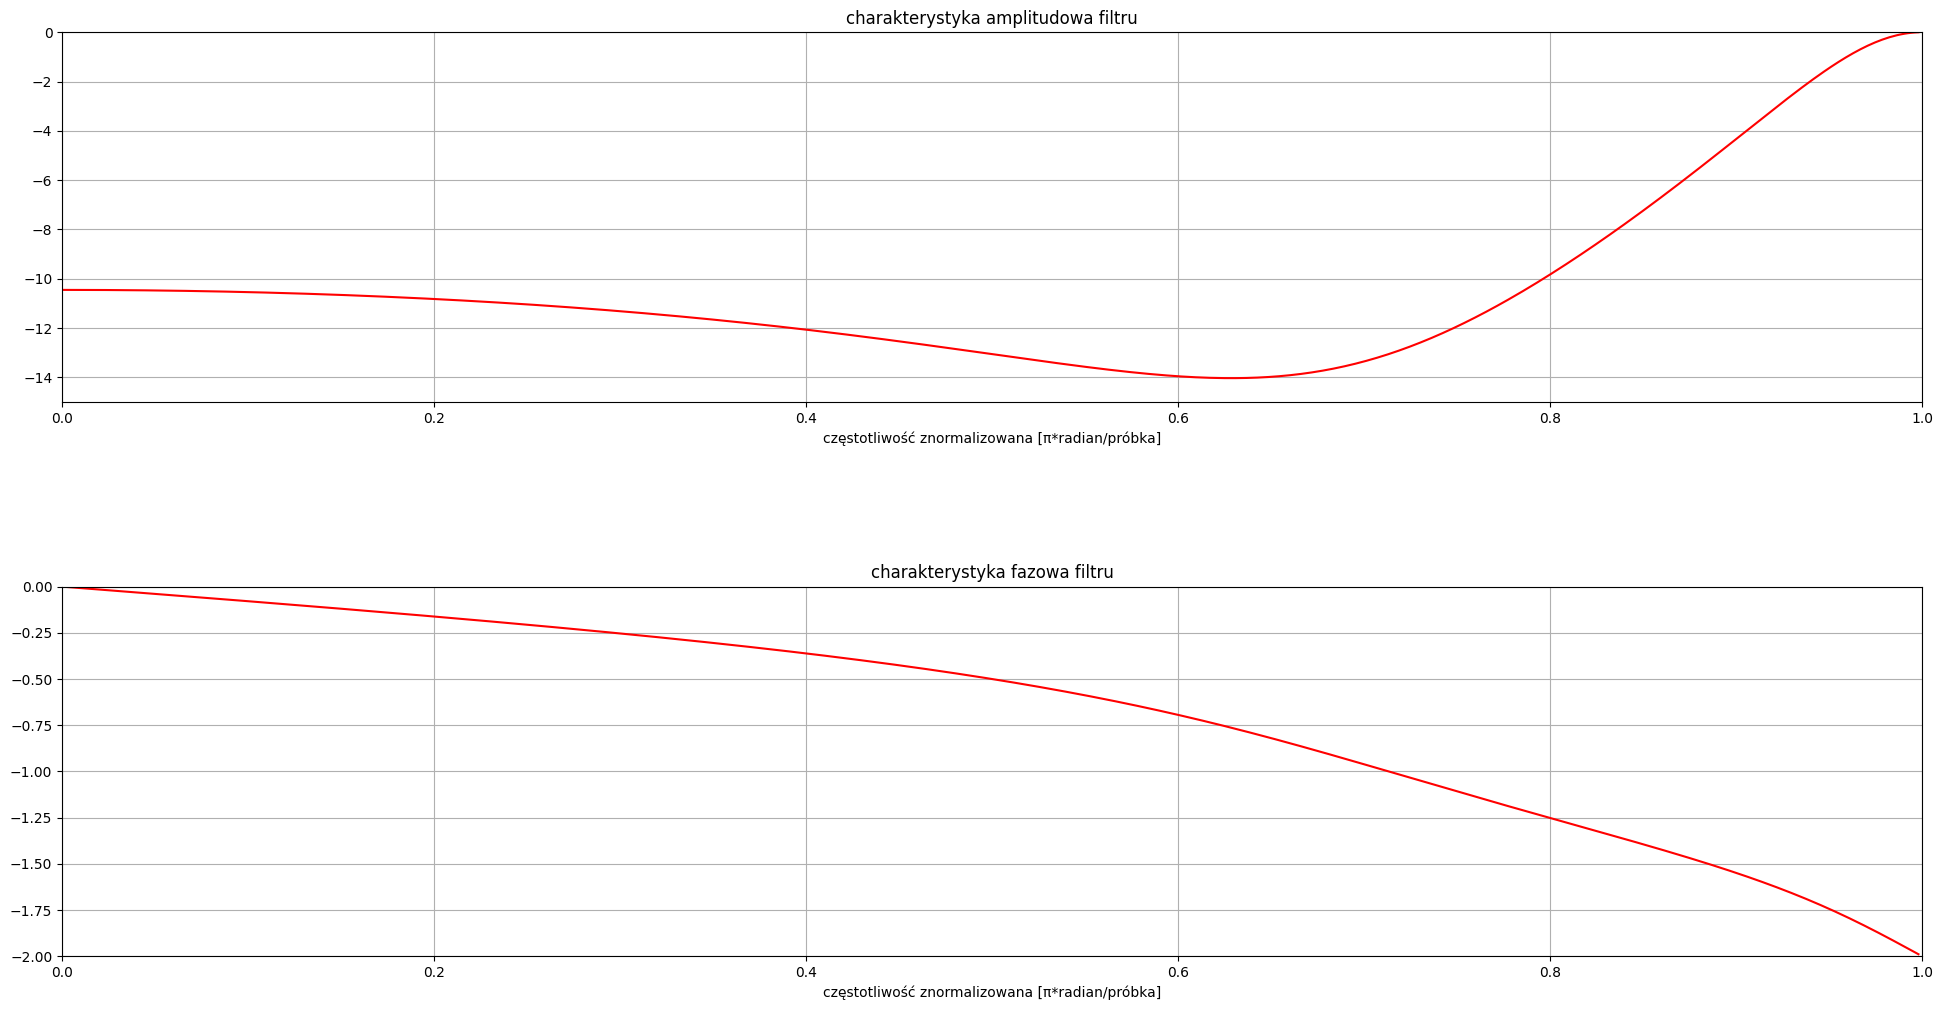

In [4]:
fig, axs = plt.subplots(2)
fig.set_size_inches(24, 12)
fig.set_dpi(DPI)
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for ax in axs:
    ax.set_xlabel('częstotliwość znormalizowana [π*radian/próbka]')
    ax.set_xlim(0, 1)
    ax.grid()

w, h = scipy.signal.freqz(B, A)
mod_h = np.abs(h)

axs[0].set_title('charakterystyka amplitudowa filtru')
axs[0].set_ylim(-15, 0)
axs[0].plot(w / np.pi, 20 * np.log10(mod_h), 'r')

axs[1].set_title('charakterystyka fazowa filtru')
axs[1].set_ylim(-2, 0)
axs[1].plot(w / np.pi, np.unwrap(np.angle(h)) / np.pi, 'r')

plt.show()

### Położenie zer i biegunów

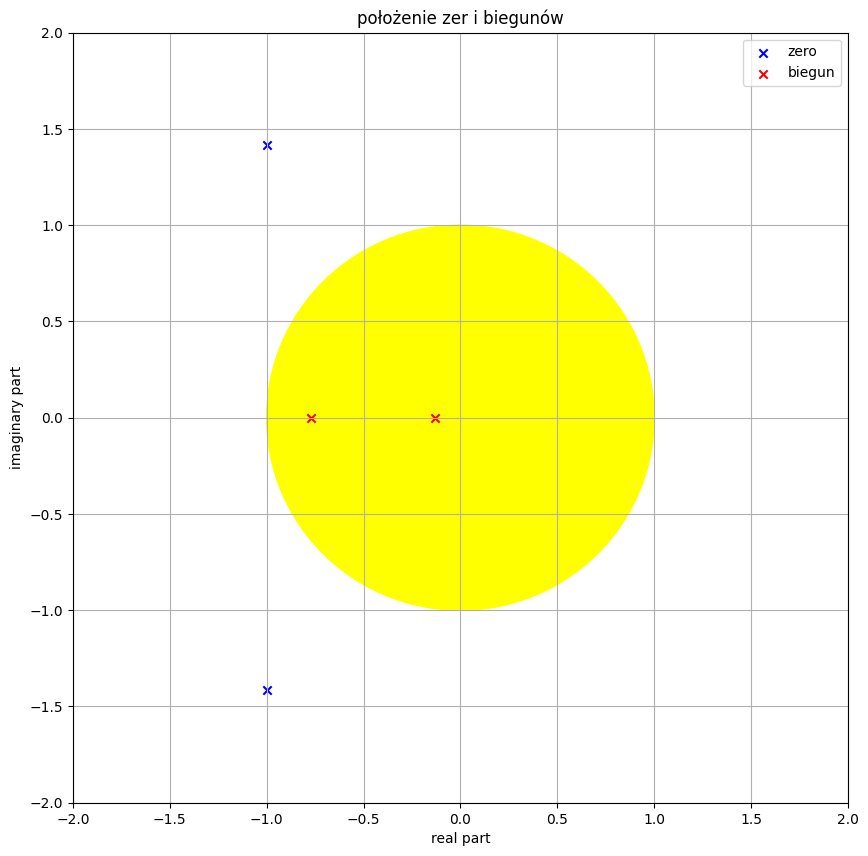

In [5]:
zeros, poles, k = scipy.signal.tf2zpk(B, A)

fig, ax = plt.subplots(1)
fig.set_size_inches(10, 10)
fig.set_dpi(DPI)

ax.add_artist(plt.Circle((0, 0), 1, color='yellow', fill=True))
ax.scatter(np.real(zeros), np.imag(zeros), color='blue', marker='x', label='zero')
ax.scatter(np.real(poles), np.imag(poles), color='red', marker='x', label='biegun')

ax.set_title('położenie zer i biegunów')
ax.set_xlabel('real part')
ax.set_ylabel('imaginary part')

ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.grid()
ax.legend()

plt.show()

### Widma amplitudowe sygnałów x[n] oraz y[n]

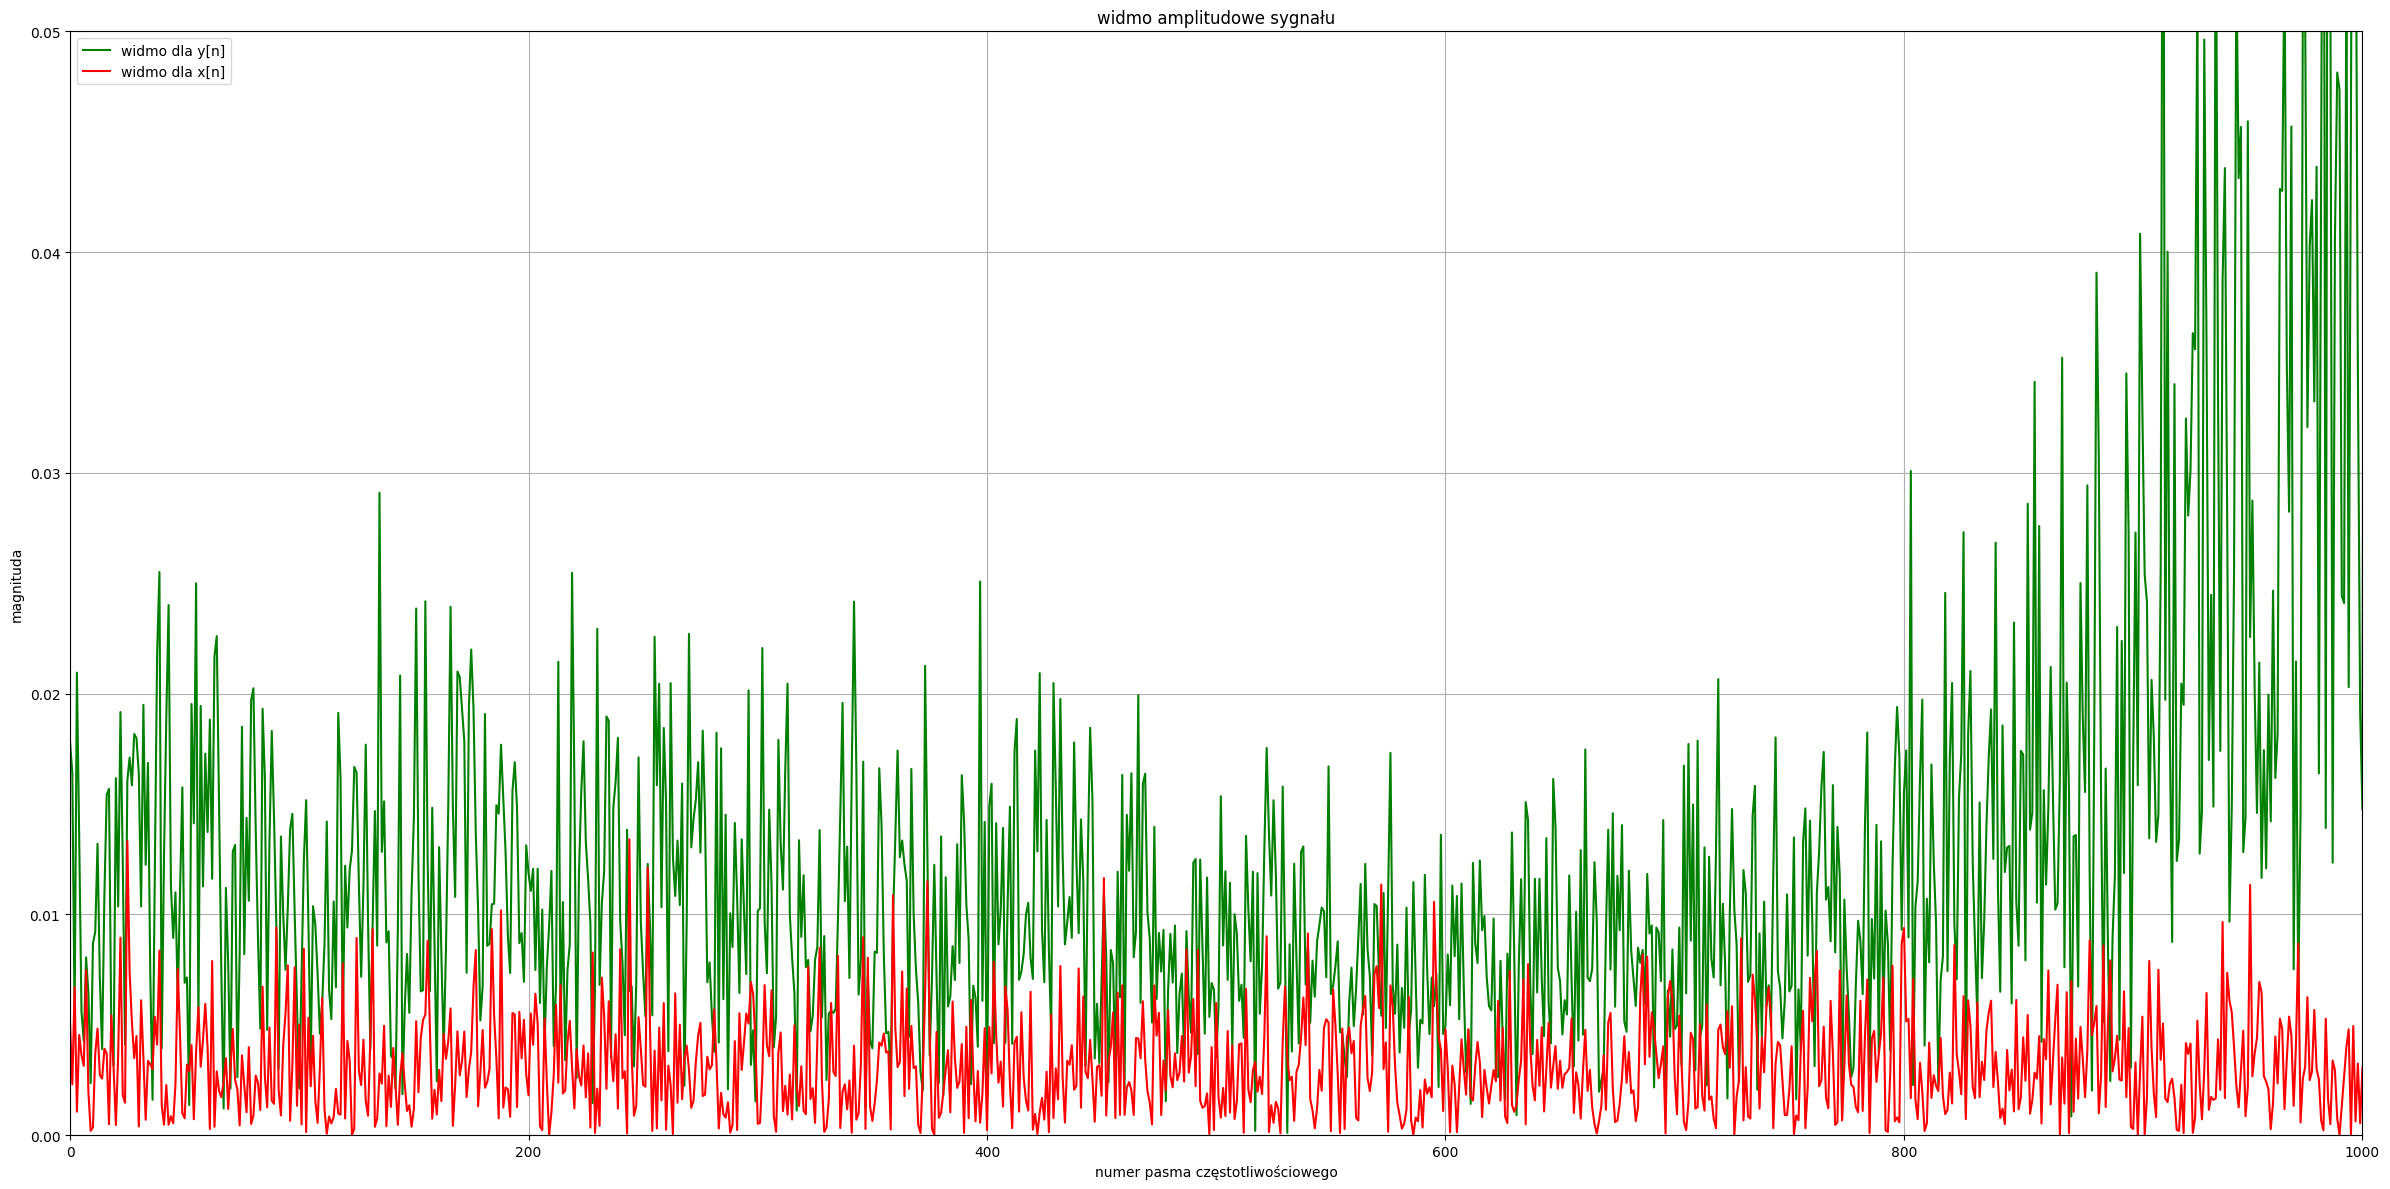

In [6]:
N = 2048

fig, ax = plt.subplots(1)
fig.set_size_inches(24, 12)
fig.set_dpi(DPI)
fig.set_tight_layout(tight=True)

ax.set_xlabel('numer pasma częstotliwościowego')
ax.set_ylabel('magnituda')
ax.set_title('widmo amplitudowe sygnału')
ax.set_xlim(0, 1000)
ax.set_ylim(0, 0.05)

x_values = np.random.normal(0, 1, N)

ax.plot(np.abs(np.fft.fft(filtr(x_values)) * 2 / N), 'g', label='widmo dla y[n]')
ax.plot(np.abs(x_values) * 8 / N, 'r', label='widmo dla x[n]')

ax.grid()
ax.legend()

plt.show()

# Zadanie 6.2
Korzystając z narzędzia filterDesigner w programie MATLAB, zaprojektować filtr dolnoprzepustowy typu FIR rzędzu 10 o częstotliwości odcięcia wynoszącej 3kHz. Powtórzyć zadanie dla filtru typu IIR o tych samych specyfikacjach. Porównać zaprojektowane filtry pod względem:
    - a) amplitudowej odpowiedzi częstotliwościowej
    - b) fazowej odpowiedzi częstotliwościowej
    - c) opóźnienia grupowego

Co można powiedzieć o różnicach pomiędzy wsponianymi filtrami na podstawie powyższych porównań?
```Odpowiedź: Różnica między filtrem FIR i IIR jest taka, że filtr FIR jest filtrem o skończonej odpowiedzi impulsowej```

### Projektowanie filtru dolnoprzepustowego typu FIR

In [7]:
FS = 8000
FP = 3000
N = 10

b_firwin = scipy.signal.firwin(N, FP / (FS / 2), window='hamming')

### Projektowanie filtru IIR o tych samych specyfikacjach

In [8]:
FS = 8000
FP = 3000
N = 10

b_butter, a_butter = scipy.signal.butter(N, FP / (FS / 2), btype='low')

### Porównanie filtrów

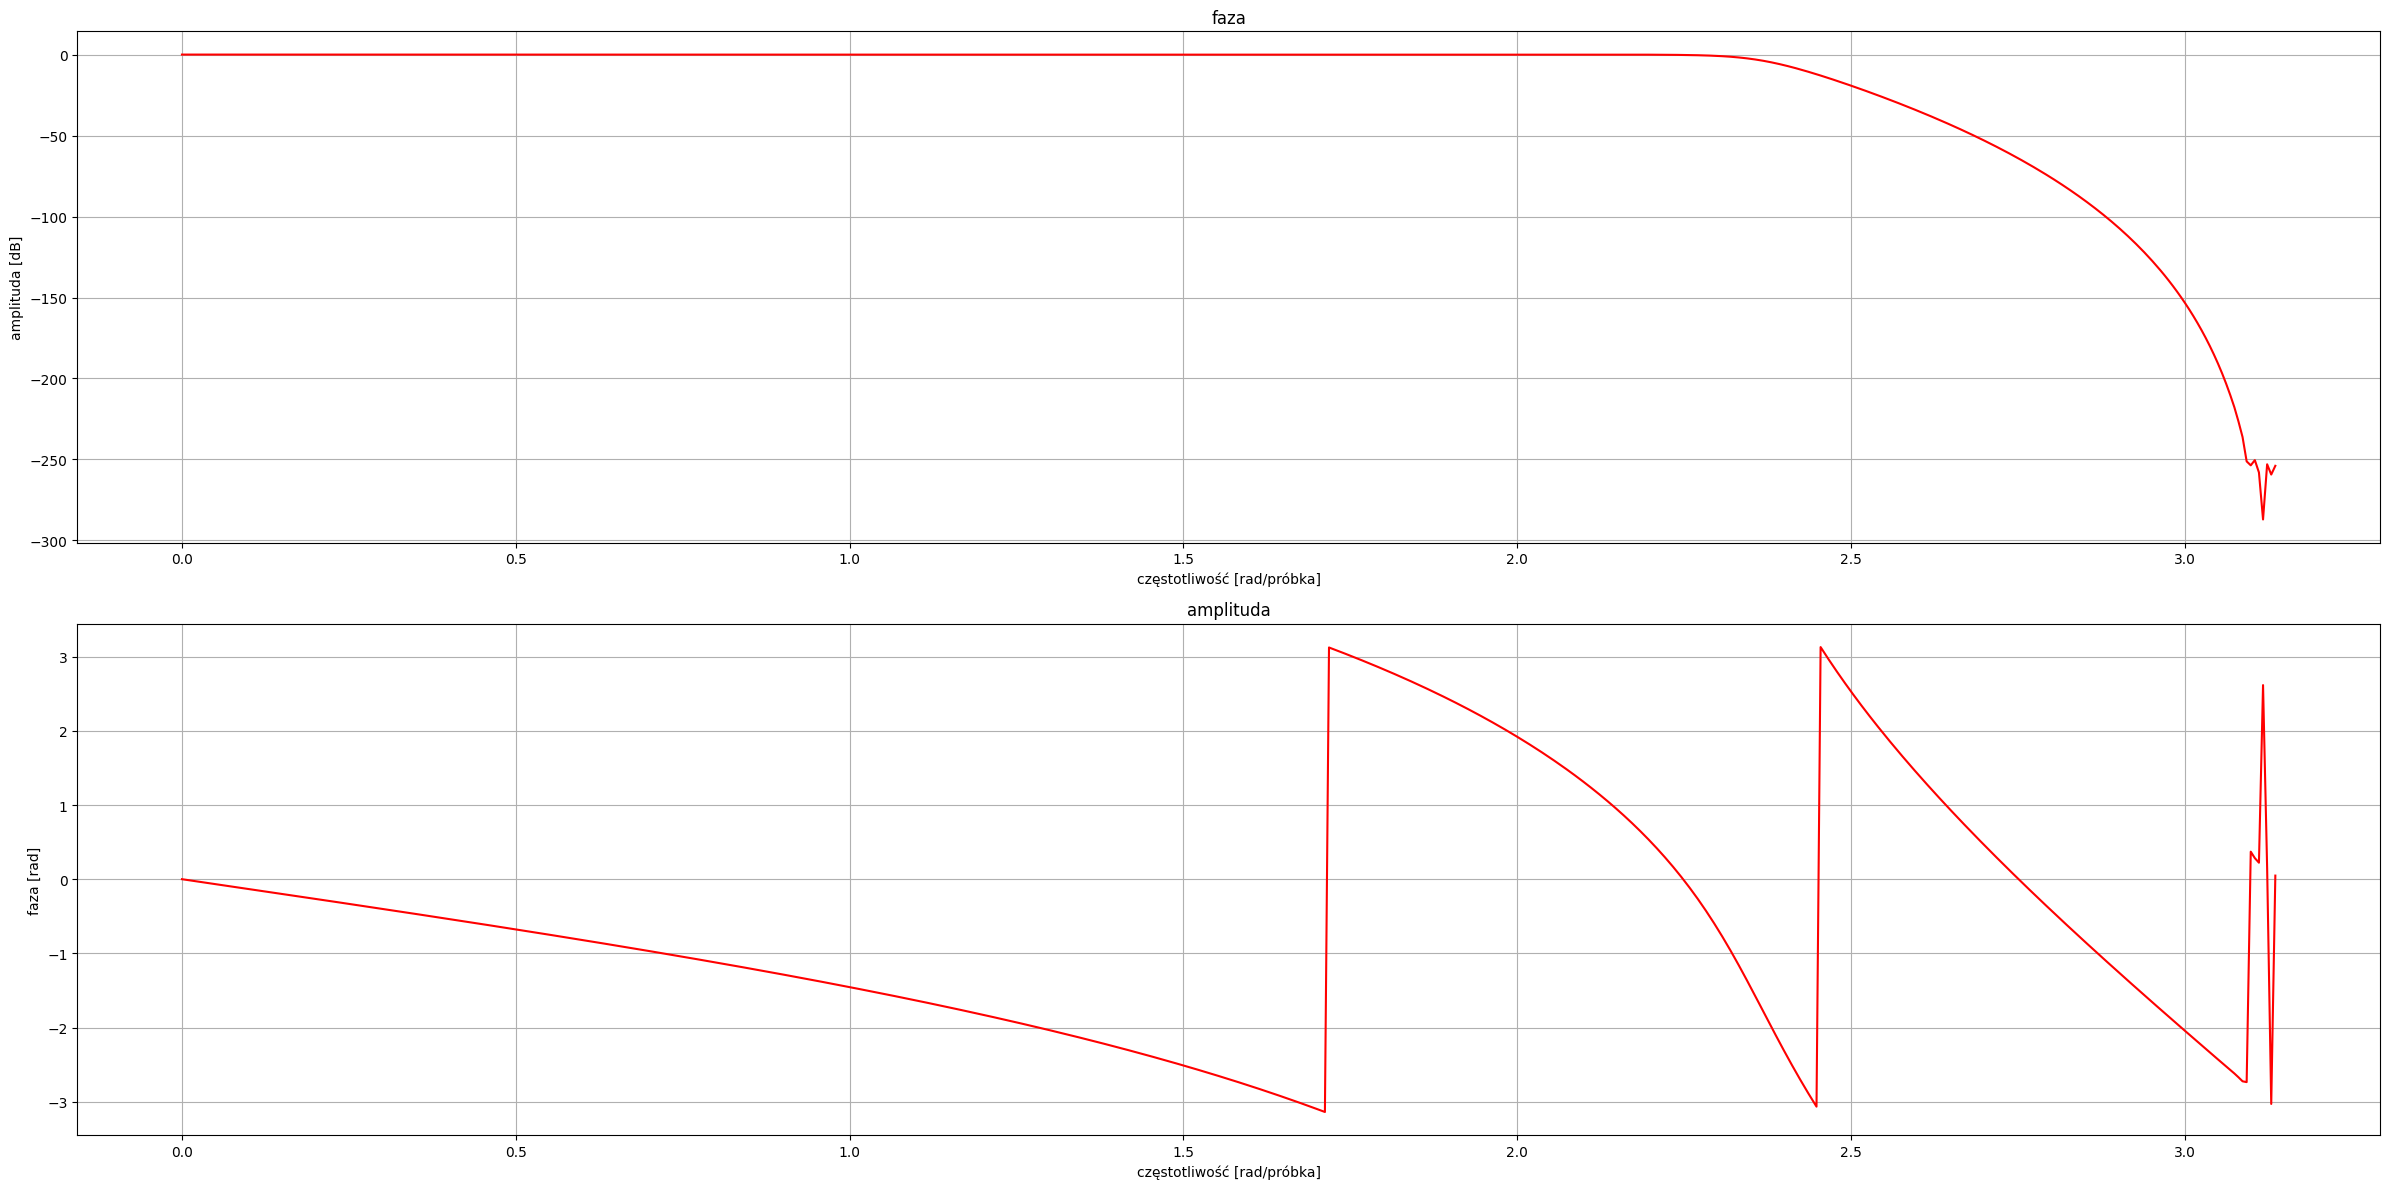

In [9]:
w, h = scipy.signal.freqz(b_butter, a_butter)

fig, axs = plt.subplots(2)
fig.set_size_inches(24, 12)
fig.set_dpi(DPI)
fig.set_tight_layout(tight=True)

axs[0].plot(w, 20 * np.log10(np.abs(h)), 'r')
axs[0].set_title('faza')
axs[0].set_xlabel('częstotliwość [rad/próbka]')
axs[0].set_ylabel('amplituda [dB]')

axs[1].plot(w, np.angle(h), 'r')
axs[1].set_title('amplituda')
axs[1].set_xlabel('częstotliwość [rad/próbka]')
axs[1].set_ylabel('faza [rad]')

for ax in axs:
    ax.grid()

plt.show()

# Zadanie 6.3
Zaprojektować filtr cyfrowy do przetwarzania sygnału mowy. Przyjąć następujące założenia projektowe:
    - filtr dolnoprzepustowy
    - częstotliwość odcięcia: 2kHz
    - typ filtru: IIR (nieskończona odpowiedź impulsowa)
    - rząd filtru 3
    - rodzaj optymalizacji: Chebyshev (typ 1)
    - zafalowania w paśmie zaporowym nie powinny przekroczyć 1 dB
    - Tłumienie w paśmie zaporowym powinno wynosić co najmniej 20 dB

Do dokumentacji wstawić:
    - a) charakterystykę amplitudową i fazową zaprojektowanego filtru
    - b) wykresy w dziedzinie czasu sygnałów na wejściu i na wyjściu filtru,
    - c) wykresy periodogramów sygnałów na wejściu i wyjściu filtru,
    - d) spektrogramy sygnałów na wejściu i wyjściu zaprojektowanego filtru,
    - e) krótki opis słowny słuchowej różnicy w brzmieniu sygnałów na wejściu i wyjściu filtru.
           ```Odpowiedź: Filtr dolnoprzepustowy o częstotliwości odcięcia 2kHz usuwa wysokie częstotliwości z podanego sygnału```


### Parametry filtru

In [10]:
FS = 8000
FP = 2000
g_pass = 1
g_stop = 20

### Projekt filtru
Funkcja cheby1 zwraca parametry filtru w postaci liczb zespolonych, które następnie mogą być użyte do filtrowania sygnału.

In [11]:
B, A = scipy.signal.cheby1(3, g_stop, FP / (FS / 2), btype='low', analog=False, output='BA')

### Charakterystyka amplitudowa i fazowa

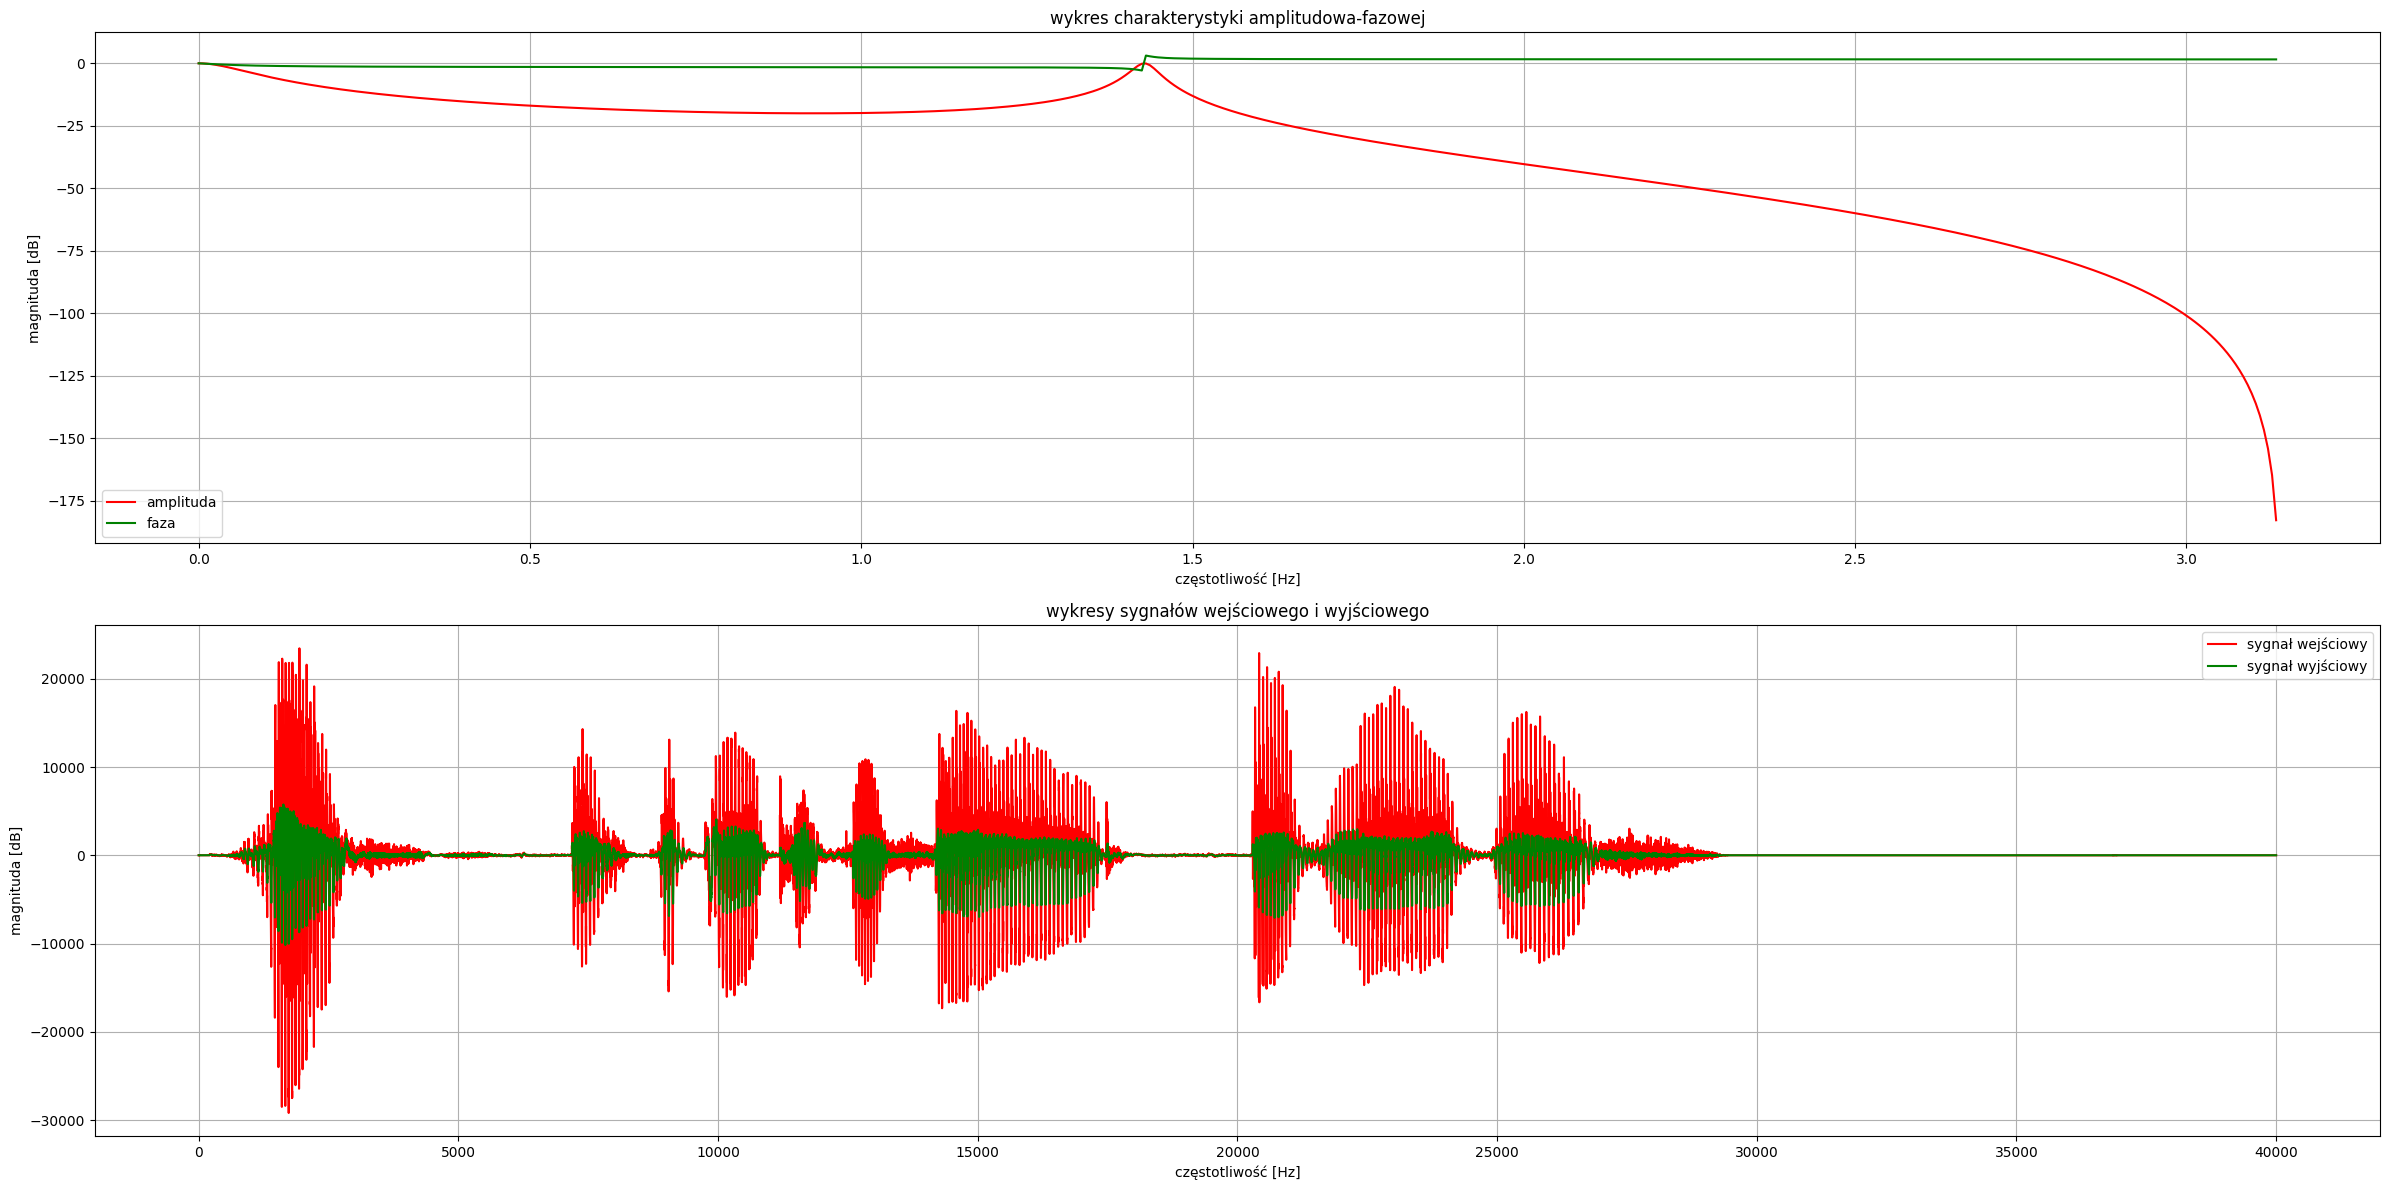

In [12]:
w, h = scipy.signal.freqz(B, A)

fig, axs = plt.subplots(2)
fig.set_size_inches(24, 12)
fig.set_dpi(DPI)
fig.set_tight_layout(tight=True)

axs[0].set_title('wykres charakterystyki amplitudowa-fazowej')
axs[0].plot(w, 20 * np.log10(np.abs(h)), 'r', label='amplituda')
axs[0].plot(w, np.angle(h), 'g', label='faza')

fs, x_values = scipy.io.wavfile.read('../audio/my_voice.wav')
y_values = scipy.signal.lfilter(B, A, x_values)

axs[1].set_title('wykresy sygnałów wejściowego i wyjściowego')
axs[1].plot(x_values, 'r', label='sygnał wejściowy')
axs[1].plot(y_values, 'g', label='sygnał wyjściowy')

for ax in axs:
    ax.set_xlabel('częstotliwość [Hz]')
    ax.set_ylabel('magnituda [dB]')
    ax.legend()
    ax.grid()

plt.show()

### Periodogramy

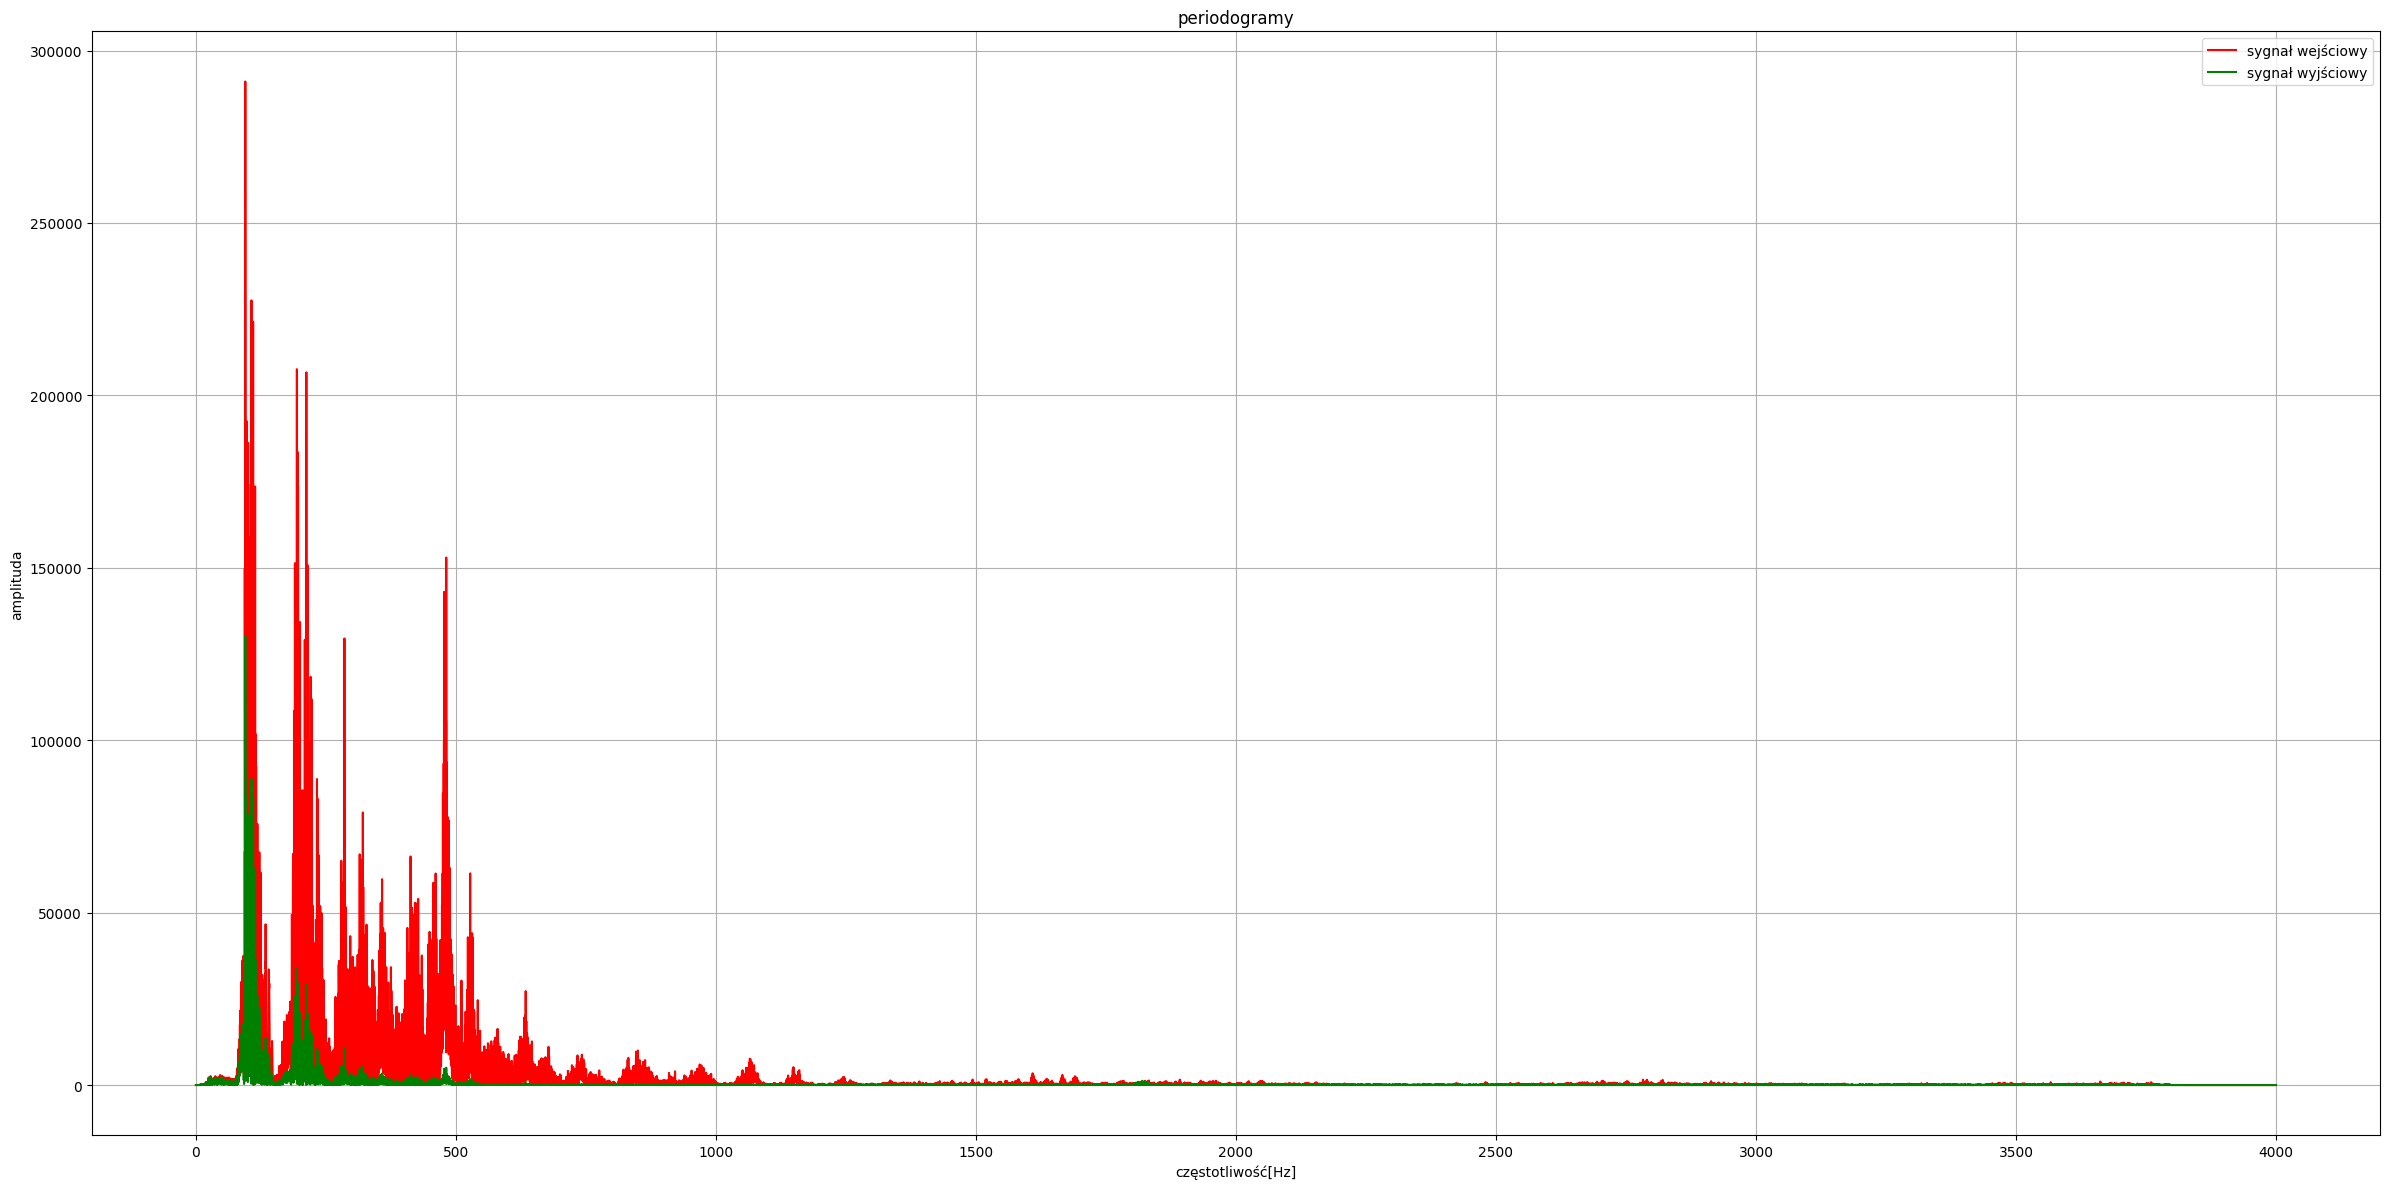

In [13]:
f, pxx = scipy.signal.periodogram(x_values, fs)
_, pyy = scipy.signal.periodogram(y_values, fs)

fig, ax = plt.subplots(1)
fig.set_size_inches(24, 12)
fig.set_dpi(DPI)
fig.set_tight_layout(tight=True)

ax.set_title('periodogramy')
ax.plot(f, pxx, 'r', label='sygnał wejściowy')
ax.plot(f, pyy, 'g', label='sygnał wyjściowy')
ax.set_ylabel('amplituda')
ax.set_xlabel('częstotliwość[Hz]')
ax.legend()
ax.grid()

plt.show()

### Spektogramy

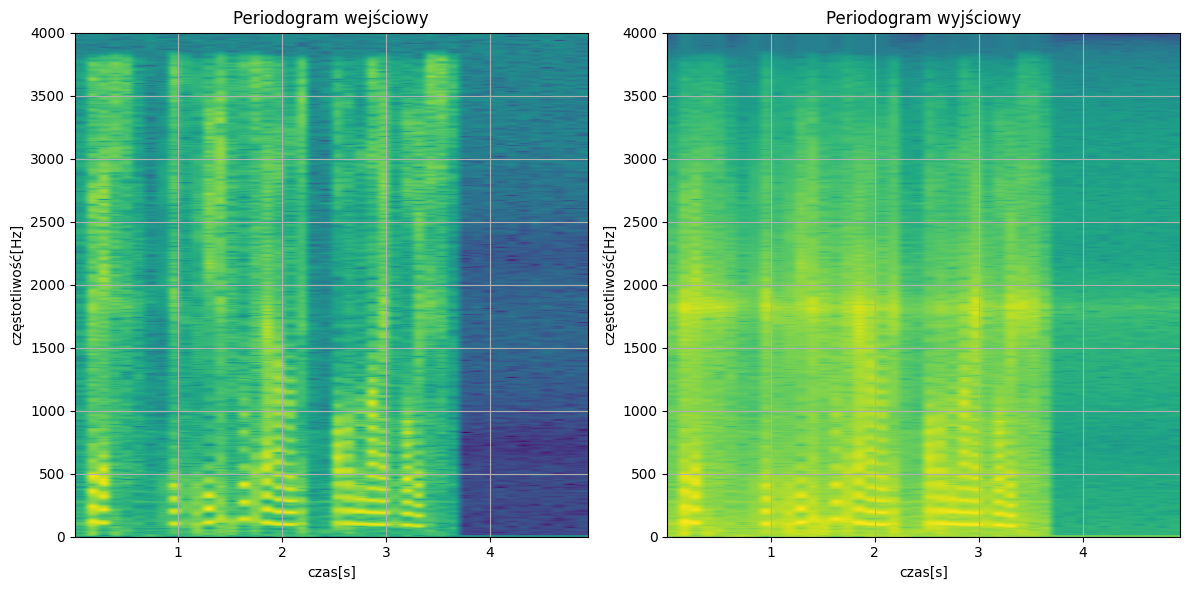

In [14]:
f, pxx = scipy.signal.periodogram(x_values, fs)
_, pyy = scipy.signal.periodogram(y_values, fs)

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(12, 6)
fig.set_dpi(DPI)
fig.set_tight_layout(tight=True)

for ax in axs:
    ax.set_ylabel('częstotliwość[Hz]')
    ax.set_xlabel('czas[s]')
    ax.grid()

axs[0].set_title('Periodogram wejściowy')
axs[0].specgram(x_values, NFFT=1024, Fs=FS)

axs[1].set_title('Periodogram wyjściowy')
axs[1].specgram(y_values, NFFT=1024, Fs=FS)

plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

# Wnioski
Filtry o nieskończonej odpowiedzi impulsowej są stabilne, jeśli ich wszystkie bieguny znajdują się wewnątrz okręgu jednostkowego.

Współczynniki filtru 'a' i 'b' można określić za pomocą funkcji optymalizujących takich jak "cheby1", "cheby2", "ellip", "bessel" z biblioteki "scipy.signal".

Charakterystykę częstotliwościową filtru można określić za pomocą funkcji "scipy.signal.freqz". Widmo amplitudowe sygnału na wyjściu jest iloczynem widma amplitudowego sygnału na wejściu i charakterystyki amplitudowej filtru.

# Podpisy
![Podpis](../signatures/006.jpg)
